In [3]:
from os.path import basename, exists

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp
from scipy.optimize import leastsq

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

Code referenced Downey, Allen (2021): https://allendowney.github.io/ModSimPy/chap18.html

In [4]:
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'glucose_insulin.csv')

'https://github.com/AllenDowney/ModSim/raw/main/data/glucose_insulin.csv'

Downloaded glucose_insulin.csv


'https://github.com/AllenDowney/ModSim/raw/main/data/glucose_insulin.csv'

In [5]:
sns.set_style('darkgrid')
sns.set_palette('husl', 10, color_codes=True)
%matplotlib inline
sns.husl_palette(10)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

We want to model a dynamic system based off of this data. We try the minimal model proposed by Bergman et al: doi:10.1152/ajpendo.1979.236.6.E667. The analysis is based off of Downey, Allen (2021): https://allendowney.github.io/ModSimPy/chap17.html.

Read in the glucose and insulin time series data:

In [6]:
df = pd.read_csv('glucose_insulin.csv', index_col='time')
df.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


Get interpolated series of glucose and insulin levels to visualize how the data evolve over time:

In [7]:
t_0 = df.index[0]
t_f = df.index[-1]
t = np.linspace(t_0, t_f, int(t_f-t_0))

G_func = UnivariateSpline(df.glucose.index, df.glucose.values, k=2, s=100)
G_series = pd.Series(G_func(t), index=t)

I = UnivariateSpline(df.insulin.index, df.insulin.values, k=1, s=200)
I_series = pd.Series(I(t), index=t)

Plot the data:

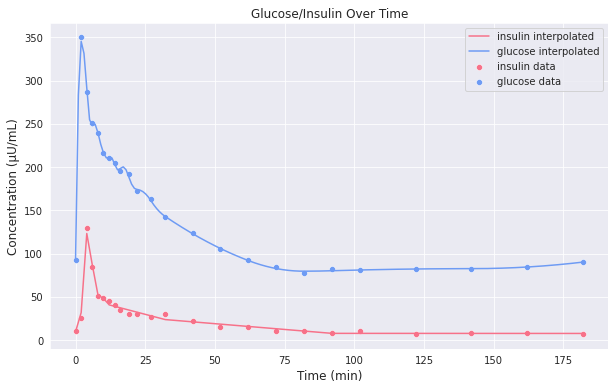

In [8]:
fig,ax = plt.subplots(figsize=(10,6), nrows=1,ncols=1)

sns.scatterplot(x=df.index, y=df.insulin,color=sns.husl_palette(10)[0], label='insulin data', ax=ax)
sns.lineplot(x=t, y=I(t), color=sns.husl_palette(10)[0], label='insulin interpolated')

sns.scatterplot(x=df.index, y=df.glucose, color=sns.husl_palette(10)[7], label='glucose data', ax=ax)
sns.lineplot(x=t, y=G_func(t), color=sns.husl_palette(10)[7], label='glucose interpolated')

ax.set_xlabel('Time (min)', size='large')
ax.set_ylabel('Concentration (μU/mL)', size='large')
ax.set_title('Glucose/Insulin Over Time')
plt.show()

After an initial spike in glucose from the first dose, we see that the insulin spikes in response to break down the glucose in the blood. As the insulin does its work, both the glucose and the insulin levels decrease. The insulin will diffuse between the blood and tissue fluid as its needed, eventually tapering off. Also in effect are the glucoses' natural levels of decrease.

In [9]:
# guess parameters for first run
G0 = 270
X0 = 0
p1 = 0.01
p2 = 0.01
p3 = 1.0e-05

# get equilibrium (basal) values of insulin and glucose
Gb = df.glucose[t_0]
Ib = df.insulin[t_0]

In [10]:
def minimal_model(t, states, p1, p2, p3):

    G = states[0]
    X = states[1]

    dGdt = -p1 * (G - Gb) - X*G
    dXdt = p3 * (I(t) - Ib) - p2 * X

    return [dGdt, dXdt]

mm_solve = solve_ivp(minimal_model, t_span=(t_0,t_f), y0=[G0, X0], args=(p1,p2,p3), method='RK45', dense_output=True)
mm_solve.success, mm_solve.message

(True, 'The solver successfully reached the end of the integration interval.')

In [11]:
mm = mm_solve.sol(t)
mm_glucose = mm[0]
mm_insulin = mm[1]

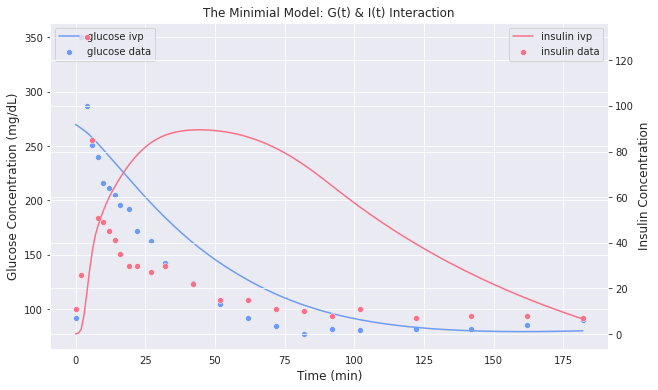

In [12]:
fig2, ax1 = plt.subplots(figsize=(10,6), nrows=1,ncols=1)

sns.lineplot(x=t, y=mm_glucose, label='glucose ivp', color=sns.husl_palette(10)[7], legend=False, ax=ax1)
sns.scatterplot(x=df.index, y=df.glucose, color=sns.husl_palette(10)[7], label='glucose data', ax=ax1)

ax1.set_xlabel('Time (min)', size='large')
ax1.set_ylabel('Glucose Concentration (mg/dL)', size='large')

ax2 = ax1.twinx()

sns.lineplot(x=t, y=mm_insulin*10**4, label='insulin ivp', color=sns.husl_palette(10)[0], legend=False, ax=ax2)
sns.scatterplot(x=df.index, y=df.insulin, color=sns.husl_palette(10)[0], label='insulin data', ax=ax2)
ax2.set_ylabel('Insulin Concentration', size='large')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.title('The Minimial Model: G(t) & I(t) Interaction', size='large')
plt.show()

We started with guesses for our parameters. We want to use our training data to minimize the error between the data points and the ODE numerical solution. To do this, we build an error function and find the parameters that find the least squared error between the data and solution.

In [13]:
def error(parameters, df):
    G0, X0 = 270, 0
    p1, p2, p3 = parameters
    sol = solve_ivp(minimal_model, t_span=(t_0,t_f), y0=[G0, X0], args=(p1,p2,p3), method='RK45', dense_output=True)
    errors = sol.sol(df.glucose.index)[0]- df.glucose.values
    # return errors starting at index 2 to allow insulin to catch up to glucose injection
    return errors[3:]

In [14]:
# start with initial value estimates
param_estimates = [0.01, 0.01, 1.0e-05]
# use scipy's leastsq function to get optimal parameter values (takes a while
# to run)
optimal_params = leastsq(error, x0=param_estimates, args=(df))[0]
print(optimal_params)

[2.37193694e-02 1.62018729e-02 1.27882227e-05]


In [15]:
mm_solve = solve_ivp(minimal_model, t_span=(t_0,t_f), y0=[G0, X0], args=optimal_params, method='RK45', dense_output=True)
mm_solve.success, mm_solve.message

(True, 'The solver successfully reached the end of the integration interval.')

In [16]:
mm = mm_solve.sol(t)
mm_glucose = mm[0]
mm_insulin = mm[1]

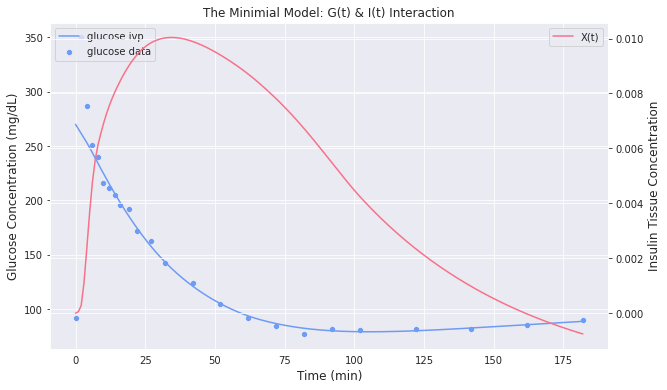

In [17]:
fig2, ax1 = plt.subplots(figsize=(10,6), nrows=1,ncols=1)

sns.lineplot(x=t, y=mm_glucose, label='glucose ivp', color=sns.husl_palette(10)[7], legend=False, ax=ax1)
sns.scatterplot(x=df.index, y=df.glucose, color=sns.husl_palette(10)[7], label='glucose data', ax=ax1)

ax1.set_xlabel('Time (min)', size='large')
ax1.set_ylabel('Glucose Concentration (mg/dL)', size='large')

ax2 = ax1.twinx()

sns.lineplot(x=t, y=mm_insulin, label='X(t)', color=sns.husl_palette(10)[0], legend=False, ax=ax2)
#sns.scatterplot(x=df.index, y=df.insulin, color=sns.husl_palette(10)[0], label='I(t) data', ax=ax2)
ax2.set_ylabel('Insulin Tissue Concentration', size='large')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.title('The Minimial Model: G(t) & I(t) Interaction', size='large')
plt.show()

In [18]:
# retrieve insulin sensitivity index, that is, ability of blood insulin to
# enhance glucose effectiveness
S_I = (optimal_params[2] / optimal_params[1]).round(5)
S_G = optimal_params[0].round(5)

print(r'Insulin Sensitivity Index (S_I):', S_I)
print('Glucose Sensitivity Index (S_G):', S_G)

Insulin Sensitivity Index (S_I): 0.00079
Glucose Sensitivity Index (S_G): 0.02372


In [19]:
S_G_interval = 1.2e-3, 4.5e-2
S_G > S_G_interval[0] or S_G < S_G_interval[1]

True

In [20]:
S_I_interval = 5.0e-5, 2.2e-3
S_I > S_I_interval[0] or S_I < S_I_interval[1]

True

Given these heuristics, we can turn quantify how a patient is processing glucose.

The results from the ODE model the glucose dispersion well. However, there's information we are missing from the Insulin response-- the ODE solution overestimates the insulin's recovery time to equilibrium. How can we employ modern machine learning techniques to improve on this model?

First lets use a support vector regression (SVR) to show the relationship between glucose blood concentration and insulin blood concentration as a result. We can use SVR to map from glucose injection to the subject's insulin movement to the blood as a response.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.glucose.values.reshape(-1,1), df.insulin.values, test_size=.2)
svr = SVR(kernel='poly').fit(X_train,y_train)
svr.score(X_test, y_test)

0.8833328652321889

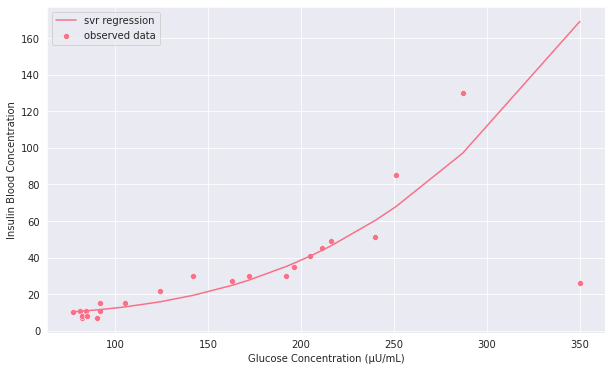

In [22]:
X = df.glucose.values
fig, ax = plt.subplots(figsize=(10,6), nrows=1,ncols=1)
ax=sns.lineplot(x=X, y=svr.predict(X.reshape(-1,1)), label='svr regression')
sns.scatterplot(x=X, y=df.insulin.values,label='observed data')
ax.set_xlabel('Glucose Concentration (μU/mL)')
ax.set_ylabel('Insulin Blood Concentration')
plt.show()

We can see that as the glucose concentration increases (as a result of sugar intake or the glucose injection) the body pushes insulin into the blood stream to break down the glucose. In the bounds of the data, the relationship is exponential, but we can't extrapolate that the pattern continues for extremely high glucose injections. Presumbly, there exists a cap on the insulin production over a certain time frame and this relationship could break down for highly irregular doses of glucose.

Next we want to try training a neural network that can approximate the solution to the ODE system. We can compare how the two approaches line up and determine if its a valid technique when normal ODE solvers fail. We use the neurodiffeq library which provides wrappers for the Pytorch library that support solving dynamic systems.

In [23]:
!pip install neurodiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.2 MB/s 
  Created wheel for neurodiffeq: filename=neurodiffeq-0.6.1-py3-none-any.whl size=127020 sha256=ad14bcb804a7beafc910f5ddaafd59e06e911b7a574357ed65f8a893a7239648
  Stored in directory: /root/.cache/pip/wheels/f3/c2/cb/688632637d6c23317358ff84bd75b8fe7fcf7d88566f93e805
Successfully built neurodiffeq


In [24]:
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.conditions import IVP
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.ode import solve_system
from neurodiffeq.generators import Generator1D

import torch
import torch.nn as nn

/usr/local/lib/python3.8/dist-packages/neurodiffeq/monitors.py:44: UserWarning: You seem to be using jupyter notebook with '%matplotlib inline' which can lead to monitor plots not updating. Consider using '%matplotlib notebook' or '%matplotlib widget' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neurodiffeq/solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


Training Progress:   0%|          | 0/20000 [00:00<?, ?it/s]

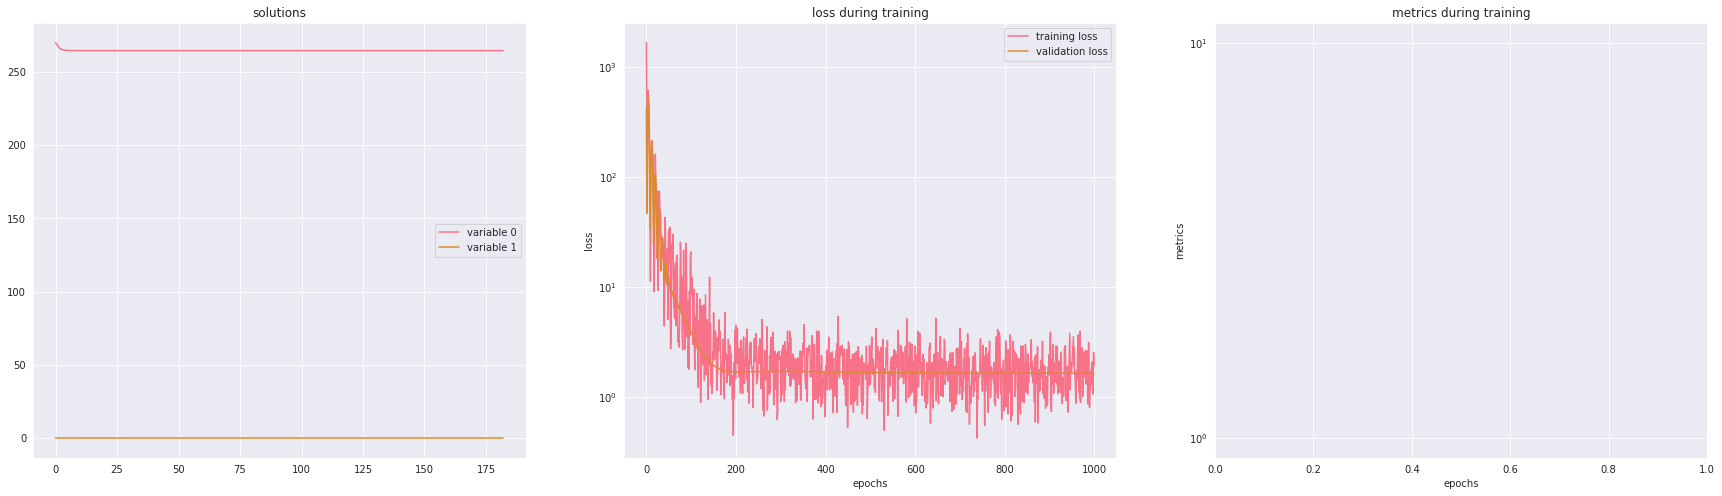

In [25]:
monitor = Monitor1D(t_min=t_0, t_max=t_f, check_every=1000)
train_gen = Generator1D(size=64,  t_min=t_0, t_max=t_f, method='uniform')
valid_gen = Generator1D(size=64, t_min=t_0, t_max=t_f, method='uniform')

def minimal_model_nn(G, X, tspan):
    dGdt = -p1*(G - Gb) - X*G
    dXdt = (torch.tensor(p3*(I(tspan.detach().numpy()) - Ib)) - p2*X)*10**4

    return [diff(G,tspan) - dGdt, diff(X,tspan) - dXdt]

conditions = [IVP(t_0=t_0, u_0=G0), IVP(t_0=t_0, u_0=X0)]
nets = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=nn.Tanh),\
        FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=nn.Tanh)]

solver = Solver1D(minimal_model_nn
                  , conditions
                  , t_min=t_0
                  , t_max=t_f
                  , nets=nets
                  , train_generator=train_gen
                  , valid_generator=valid_gen)

solver.fit(max_epochs=20000, monitor=monitor)
solution = solver.get_solution()

In [26]:
G_nn, X_nn = solution(t, to_numpy=True)

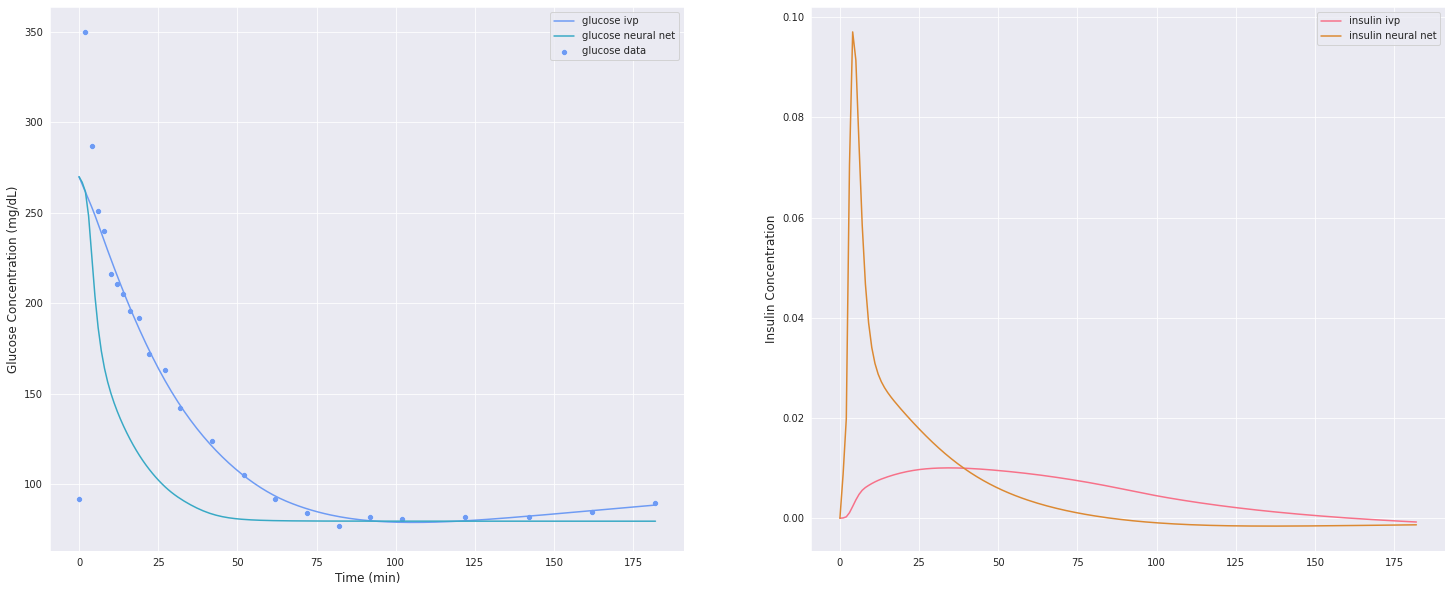

In [32]:
fig, ax = plt.subplots(figsize=(25,10), nrows=1,ncols=2)

sns.lineplot(x=t, y=mm_glucose, label='glucose ivp', color=sns.husl_palette(10)[7], legend=False, ax=ax[0])
sns.lineplot(x=t, y=G_nn, label='glucose neural net', color=sns.husl_palette(10)[6], legend=False, ax=ax[0])
sns.scatterplot(x=df.index, y=df.glucose, color=sns.husl_palette(10)[7], label='glucose data', ax=ax[0])

ax[0].set_xlabel('Time (min)', size='large')
ax[0].set_ylabel('Glucose Concentration (mg/dL)', size='large')


sns.lineplot(x=t, y=mm_insulin, label='insulin ivp', color=sns.husl_palette(10)[0], legend=False, ax=ax[1])
sns.lineplot(x=t, y=X_nn, label='insulin neural net', color=sns.husl_palette(10)[1], legend=False, ax=ax[1])
ax[1].set_ylabel('Insulin Concentration', size='large')

ax[0].legend()
ax[1].legend()

plt.show()

On reflection, its very tricky to get the neural networks to work how we want. They are very tempermental to the architectures and it can be difficult to get right. The function tended to model the data better with a greater number of epochs, essentially needing more training time to fit the solution. With different architectures we might be able to converge more quickly with the same number of epochs. Based on the data, it looks like the numerical solver was able to model the system better G(t), but the neural net was able to adjust to the quick drop in insulin concentration better than the numerical solver.

Below is a nicely solved Lotka-Volterra System using Neural Nets, courtesy of the documentation in neurodiffeq: https://neurodiffeq.readthedocs.io/en/latest/getstart.html#Systems-of-ODE-Example-2:-Lotka–Volterra-equations

/usr/local/lib/python3.8/dist-packages/neurodiffeq/monitors.py:44: UserWarning: You seem to be using jupyter notebook with '%matplotlib inline' which can lead to monitor plots not updating. Consider using '%matplotlib notebook' or '%matplotlib widget' instead.
  warnings.warn(


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

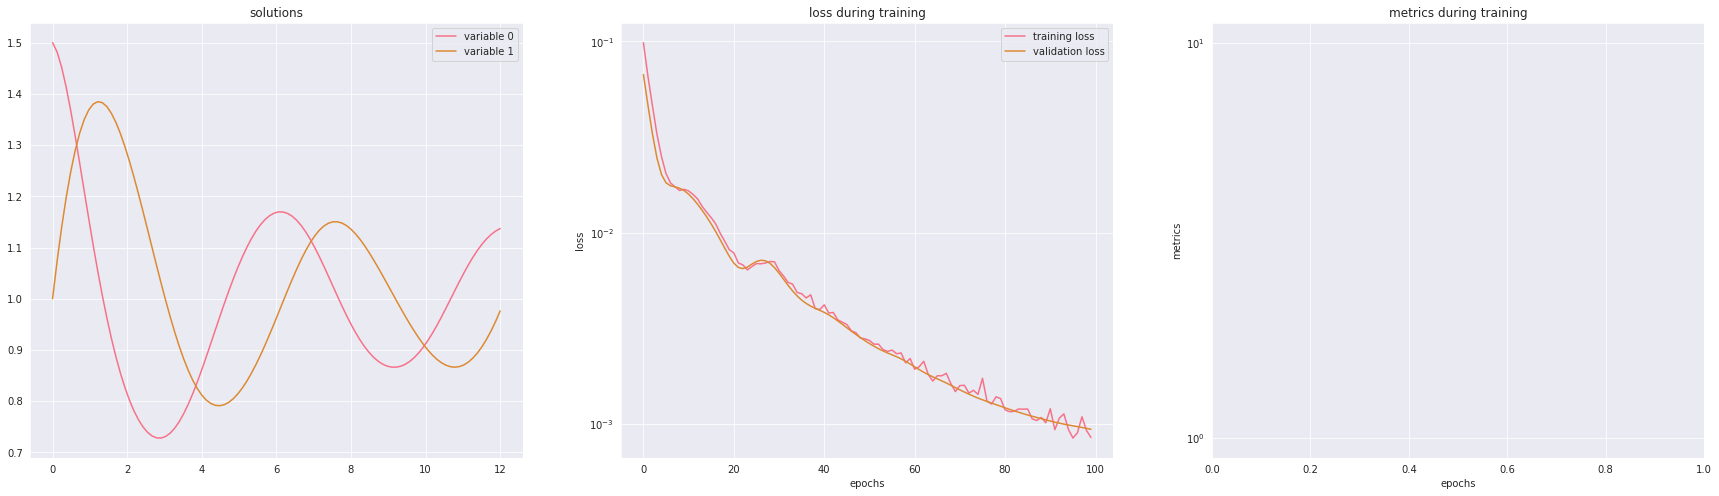

In [28]:
# specify the ODE system and its parameters
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda u, v, t : [ diff(u, t) - (alpha*u  - beta*u*v),
                                    diff(v, t) - (delta*u*v - gamma*v), ]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, u_0=1.5),  # 1.5 is the value of u at t_0 = 0.0
    IVP(t_0=0.0, u_0=1.0),  # 1.0 is the value of v at t_0 = 0.0
]

# specify the network to be used to approximate each dependent variable
# the input units and output units default to 1 for FCNN
nets_lv = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv),
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv)
]

# Let's create a monitor first
monitor = Monitor1D(t_min=0.0, t_max=12.0, check_every=100)
# ... and turn it into a Callback instance
monitor_callback = monitor.to_callback()

# Instantiate a solver instance
solver = Solver1D(
    ode_system=lotka_volterra,
    conditions=init_vals_lv,
    t_min=0.1,
    t_max=12.0,
    nets=nets_lv,
)

# Fit the solver (i.e., train the neural networks)
solver.fit(max_epochs=3000, callbacks=[monitor_callback])

# Get the solution
solution_lv = solver.get_solution()

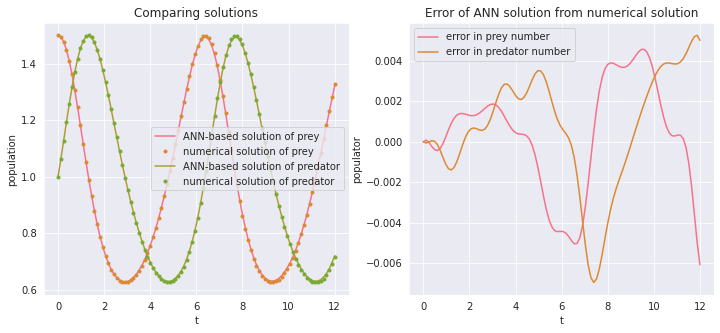

In [29]:
ts = np.linspace(0, 12, 100)

# ANN-based solution
prey_net, pred_net = solution_lv(ts, to_numpy=True)

# numerical solution
from scipy.integrate import odeint
def dPdt(P, t):
    return [P[0]*alpha - beta*P[0]*P[1], delta*P[0]*P[1] - gamma*P[1]]
P0 = [1.5, 1.0]
Ps = odeint(dPdt, P0, ts)
prey_num = Ps[:,0]
pred_num = Ps[:,1]

fig = plt.figure(figsize=(12, 5))
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(ts, prey_net, label='ANN-based solution of prey')
ax1.plot(ts, prey_num, '.', label='numerical solution of prey')
ax1.plot(ts, pred_net, label='ANN-based solution of predator')
ax1.plot(ts, pred_num, '.', label='numerical solution of predator')
ax1.set_ylabel('population')
ax1.set_xlabel('t')
ax1.set_title('Comparing solutions')
ax1.legend()

ax2.set_title('Error of ANN solution from numerical solution')
ax2.plot(ts, prey_net-prey_num, label='error in prey number')
ax2.plot(ts, pred_net-pred_num, label='error in predator number')
ax2.set_ylabel('populator')
ax2.set_xlabel('t')
ax2.legend()